# Penguins Clustering With MiniBatchKMeans

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
sns.set_palette(palette= "hls")
sns.set_style(style= "darkgrid")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/clustering-penguins-species/penguins.csv


## Load Data

In [2]:
data = pd.read_csv("/kaggle/input/clustering-penguins-species/penguins.csv")
dataset = data.copy()
data.head(10)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
5,39.3,20.6,190.0,3650.0,MALE
6,38.9,17.8,181.0,3625.0,FEMALE
7,39.2,19.6,195.0,4675.0,MALE
8,34.1,18.1,193.0,3475.0,NaN
9,42.0,20.2,5000.0,4250.0,MALE


In [3]:
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000


### Drop Outliers
As we can see in the last cell, there are several out of range values in the 'flipper_length_mm' column.

In [4]:
dataset.drop(dataset[dataset['flipper_length_mm'] > 4500].index, inplace= True)
dataset.drop(dataset[dataset['flipper_length_mm'] < 0].index, inplace= True)

### Look for NaN values

In [5]:
dataset.isna().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

In [6]:
dataset.fillna(method= "ffill", inplace= True)
dataset.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

### Change from mm to M and g to Kg

In [7]:
mm = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']
g = ['body_mass_g']

dataset[mm] = dataset[mm] / 10.
dataset[g] = dataset[g] / 1000.

dataset.rename(
    columns= {
        'culmen_length_mm':'culmen_length_cm', 
        'culmen_depth_mm': 'culmen_depth_cm',
        'flipper_length_mm':'flipper_length_cm',
        'body_mass_g':'body_mass_kg'}, inplace= True)
dataset.head(10)

,culmen_length_cm,culmen_depth_cm,flipper_length_cm,body_mass_kg,sex
0,3.91,1.87,18.1,3.750,MALE
1,3.95,1.74,18.6,3.800,FEMALE
2,4.03,1.80,19.5,3.250,FEMALE
3,4.03,1.80,19.5,3.250,FEMALE
4,3.67,1.93,19.3,3.450,FEMALE
5,3.93,2.06,19.0,3.650,MALE
6,3.89,1.78,18.1,3.625,FEMALE
7,3.92,1.96,19.5,4.675,MALE
8,3.41,1.81,19.3,3.475,MALE
10,3.78,1.71,18.6,3.300,MALE


### Feature Engineering

In [8]:
columns= ['culmen_volume_cm2', 'flipper_length_cm','body_mass_kg', 'sex']
dataset['culmen_volume_cm2'] = dataset['culmen_length_cm'] * dataset['culmen_depth_cm']
dataset = dataset[columns]
dataset.head(5)

,culmen_volume_cm2,flipper_length_cm,body_mass_kg,sex
0,7.3117,18.1,3.75,MALE
1,6.8730,18.6,3.80,FEMALE
2,7.2540,19.5,3.25,FEMALE
3,7.2540,19.5,3.25,FEMALE
4,7.0831,19.3,3.45,FEMALE


### Visualize the Data

In [9]:
def plot_data(title, columns, hue= None):
    sns.scatterplot(data= dataset, x= columns[0], y= columns[1], hue= hue)
    plt.xlabel(columns[0].replace("_", " "))
    plt.ylabel(columns[1].replace("_", " "))
    plt.title(title)
    plt.show()

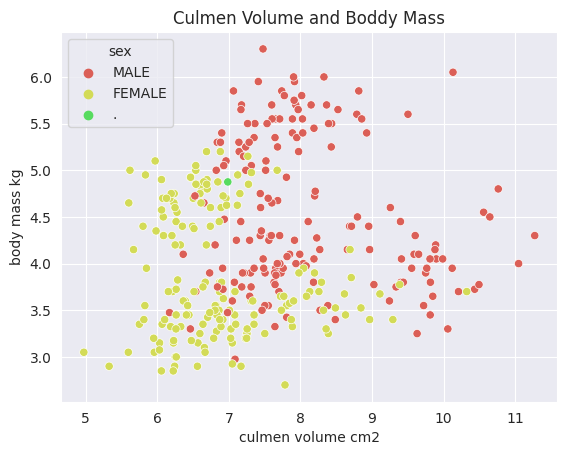

In [10]:
plot_data(title= "Culmen Volume and Boddy Mass", columns= ['culmen_volume_cm2','body_mass_kg'], hue= "sex")

In [11]:
# Fix the '.' sex value.
dataset.loc[dataset["sex"] == ".", "sex"] = "FEMALE"

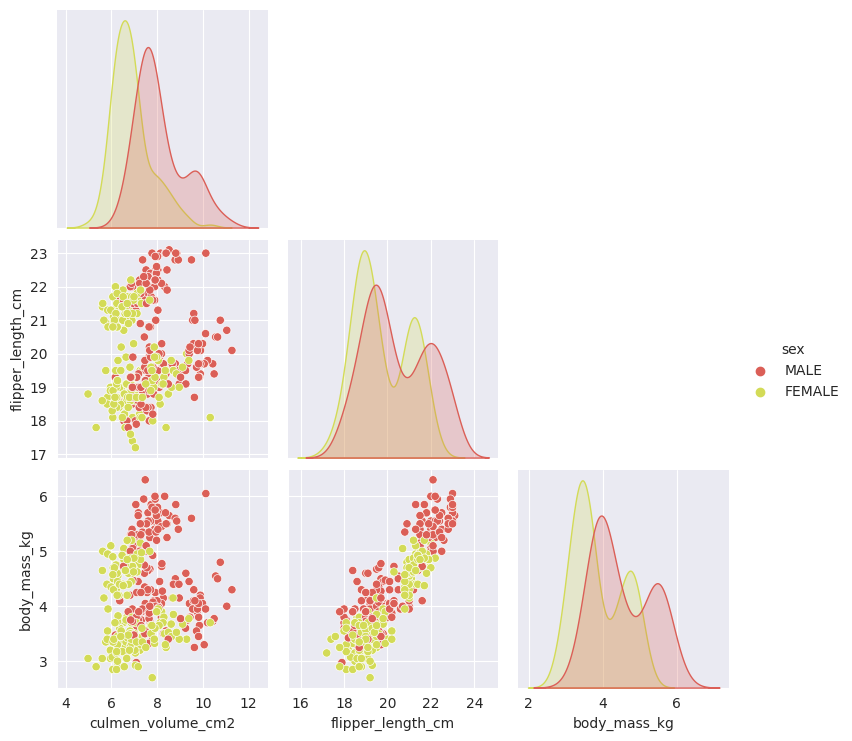

In [12]:
sns.pairplot(data= dataset, hue= "sex", corner= True)

### 

### Data Preprocessing

In [13]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X = ss.fit_transform(dataset.iloc[:, :-1])
X[1, :]

array([-0.54551693, -1.06601268, -0.4983955 ])

### MiniBatchKmeans

#### Elbow Technique

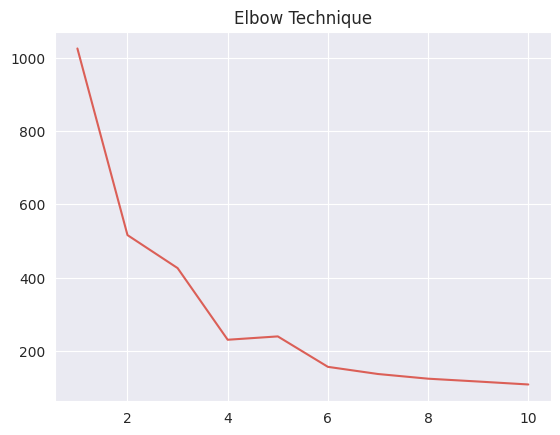

In [14]:
columns = ['culmen_volume_cm2', 'body_mass_kg', 'flipper_length_cm']
inertia = []
for n in range(1, 11):
    kmeans = KMeans(
        n_clusters= n,
        n_init= "auto",
        max_iter= 100,
        #batch_size= 1024
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

sns.lineplot(x= np.arange(1,11), y= inertia)
plt.title("Elbow Technique")
plt.show()

#### Building the Clusters

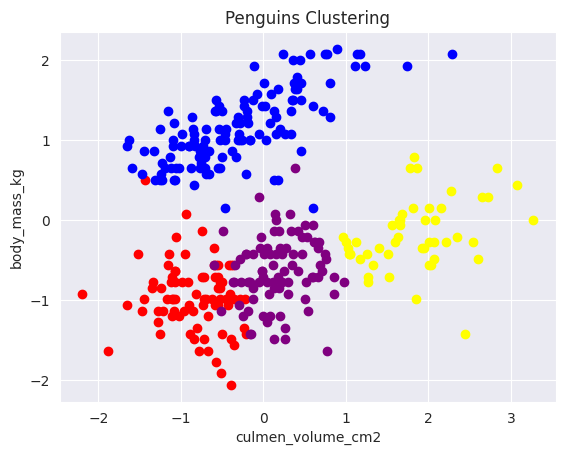

In [15]:
clustering = MiniBatchKMeans(n_clusters= 4, n_init= "auto")
clustering.fit(X)
labels = clustering.labels_

cols = ["red",'blue','yellow','purple','green','orange','crimson','dodgerblue']
for i in np.unique(clustering.labels_):
    plt.scatter(x= X[labels == i, 0], 
                y= X[labels == i,1], 
                color= cols[i])
plt.xlabel('culmen_volume_cm2')
plt.ylabel('body_mass_kg')
plt.title("Penguins Clustering")
plt.show()

### We apply KernelPCA to the data

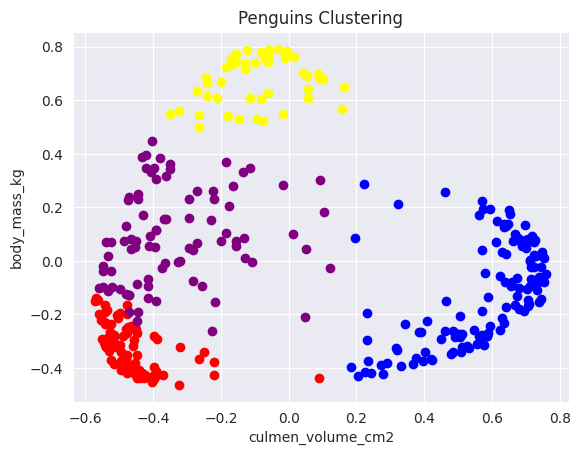

In [16]:
kpca = KernelPCA(n_components= 2, kernel= "rbf", gamma= 0.19)
x_kpca = kpca.fit_transform(X)

for i in np.unique(clustering.labels_):
    plt.scatter(x= x_kpca[labels == i, 0], 
                y= x_kpca[labels == i,1], 
                color= cols[i])
plt.xlabel('culmen_volume_cm2')
plt.ylabel('body_mass_kg')
plt.title("Penguins Clustering")
plt.show()

### Lets build the clusters one more time.

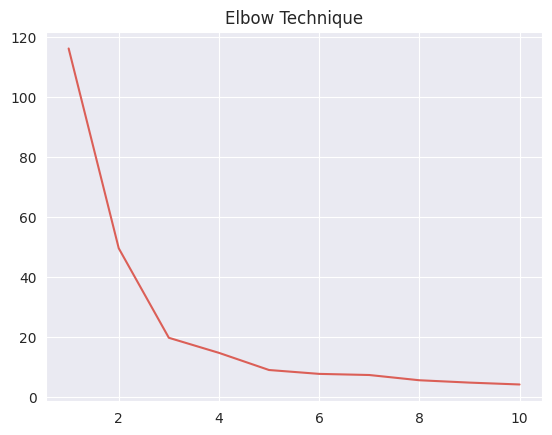

In [17]:
columns = ['culmen_volume_cm2', 'body_mass_kg', 'flipper_length_cm']
inertia = []
for n in range(1, 11):
    kmeans2 = KMeans(
        n_clusters= n,
        n_init= "auto",
        max_iter= 100,
        #batch_size= 1024
    )
    kmeans2.fit(x_kpca)
    inertia.append(kmeans2.inertia_)

sns.lineplot(x= np.arange(1,11), y= inertia)
plt.title("Elbow Technique")
plt.show()

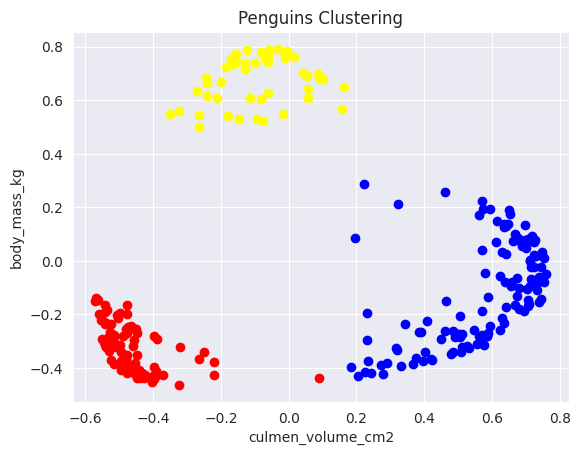

In [18]:
clustering2 = MiniBatchKMeans(n_clusters= 3, n_init= "auto")
clustering2.fit(x_kpca)
labels = clustering.labels_

cols = ["red",'blue','yellow','purple','green','orange','crimson','dodgerblue']
for i in np.unique(clustering2.labels_):
    plt.scatter(x= x_kpca[labels == i, 0], 
                y= x_kpca[labels == i,1], 
                color= cols[i])
plt.xlabel('culmen_volume_cm2')
plt.ylabel('body_mass_kg')
plt.title("Penguins Clustering")
plt.show()